# Neck Circumference

This notebooks investigates all the possible causal paths between Sex, Height, BMI and Neck Circumference ( or any possible Ansur antropometric variable). Ultimately the goal is to assess and estimated the causal effect of Sex, Height and BMI on antropometric measurements.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import arviz as az
import pymc as pm
import pandas as pd
import seaborn as sns
import networkx as nx
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
%config InlineBackend.figure_format = 'retina'
az.style.use("default")
plt.rcParams.update({'font.size': 12})

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


After reading the dataset from csv files: 
- The height given in millimeters is converted to centimeters.
- The weight is transformed into kilograms.
- BMI is computed based on the transformed height and weight values.
- The Gender column is converted into binary categorical variables. 1 represents Male, and 0 represents Female.

In [2]:
ansur_male = pd.read_csv("data/ANSUR2Distribution/Distribution/ANSUR II MALE Public.csv", encoding='latin-1') # 4082 samples
ansur_female = pd.read_csv("data/ANSUR2Distribution/Distribution/ANSUR II FEMALE Public.csv", encoding='latin-1') # 1986 samples
# Fix column name (hat tip: https://www.kaggle.com/seshadrikolluri/anthropometric-data-analysis-and-visualization)
ansur_female = ansur_female.rename(columns= {"SubjectId":"subjectid"}) 
# Combine the data and set the subjectid as index
ansur = pd.concat([ansur_male, ansur_female])
# Fix weight&stature column
ansur["stature"] = ansur["stature"]/10
ansur["weightkg"] = ansur["weightkg"]/10
ansur["neckcircumference"] = ansur["neckcircumference"]/10
ansur["BMI"] = ansur['weightkg'] / (ansur['stature']/100) **2
# Subset
columns = ['stature','BMI','neckcircumference','Gender']
subset = ansur[columns].copy()
stats = subset.groupby("Gender")[["stature","BMI",'neckcircumference']].describe()
subset['Gender'] = subset['Gender'].replace(['Male','Female'],['1','0']) # male and female with idicator variable 1== Male

In [3]:
ansur_circ = subset.neckcircumference
# height
height_std = subset.stature.std()
height_mean = subset.stature.mean()
ansur_height = subset.stature
# BMI
bmi_std = subset.BMI.std()
bmi_mean = subset.BMI.mean()
ansur_bmi = subset.BMI
s_index = subset["Gender"].astype(int).values

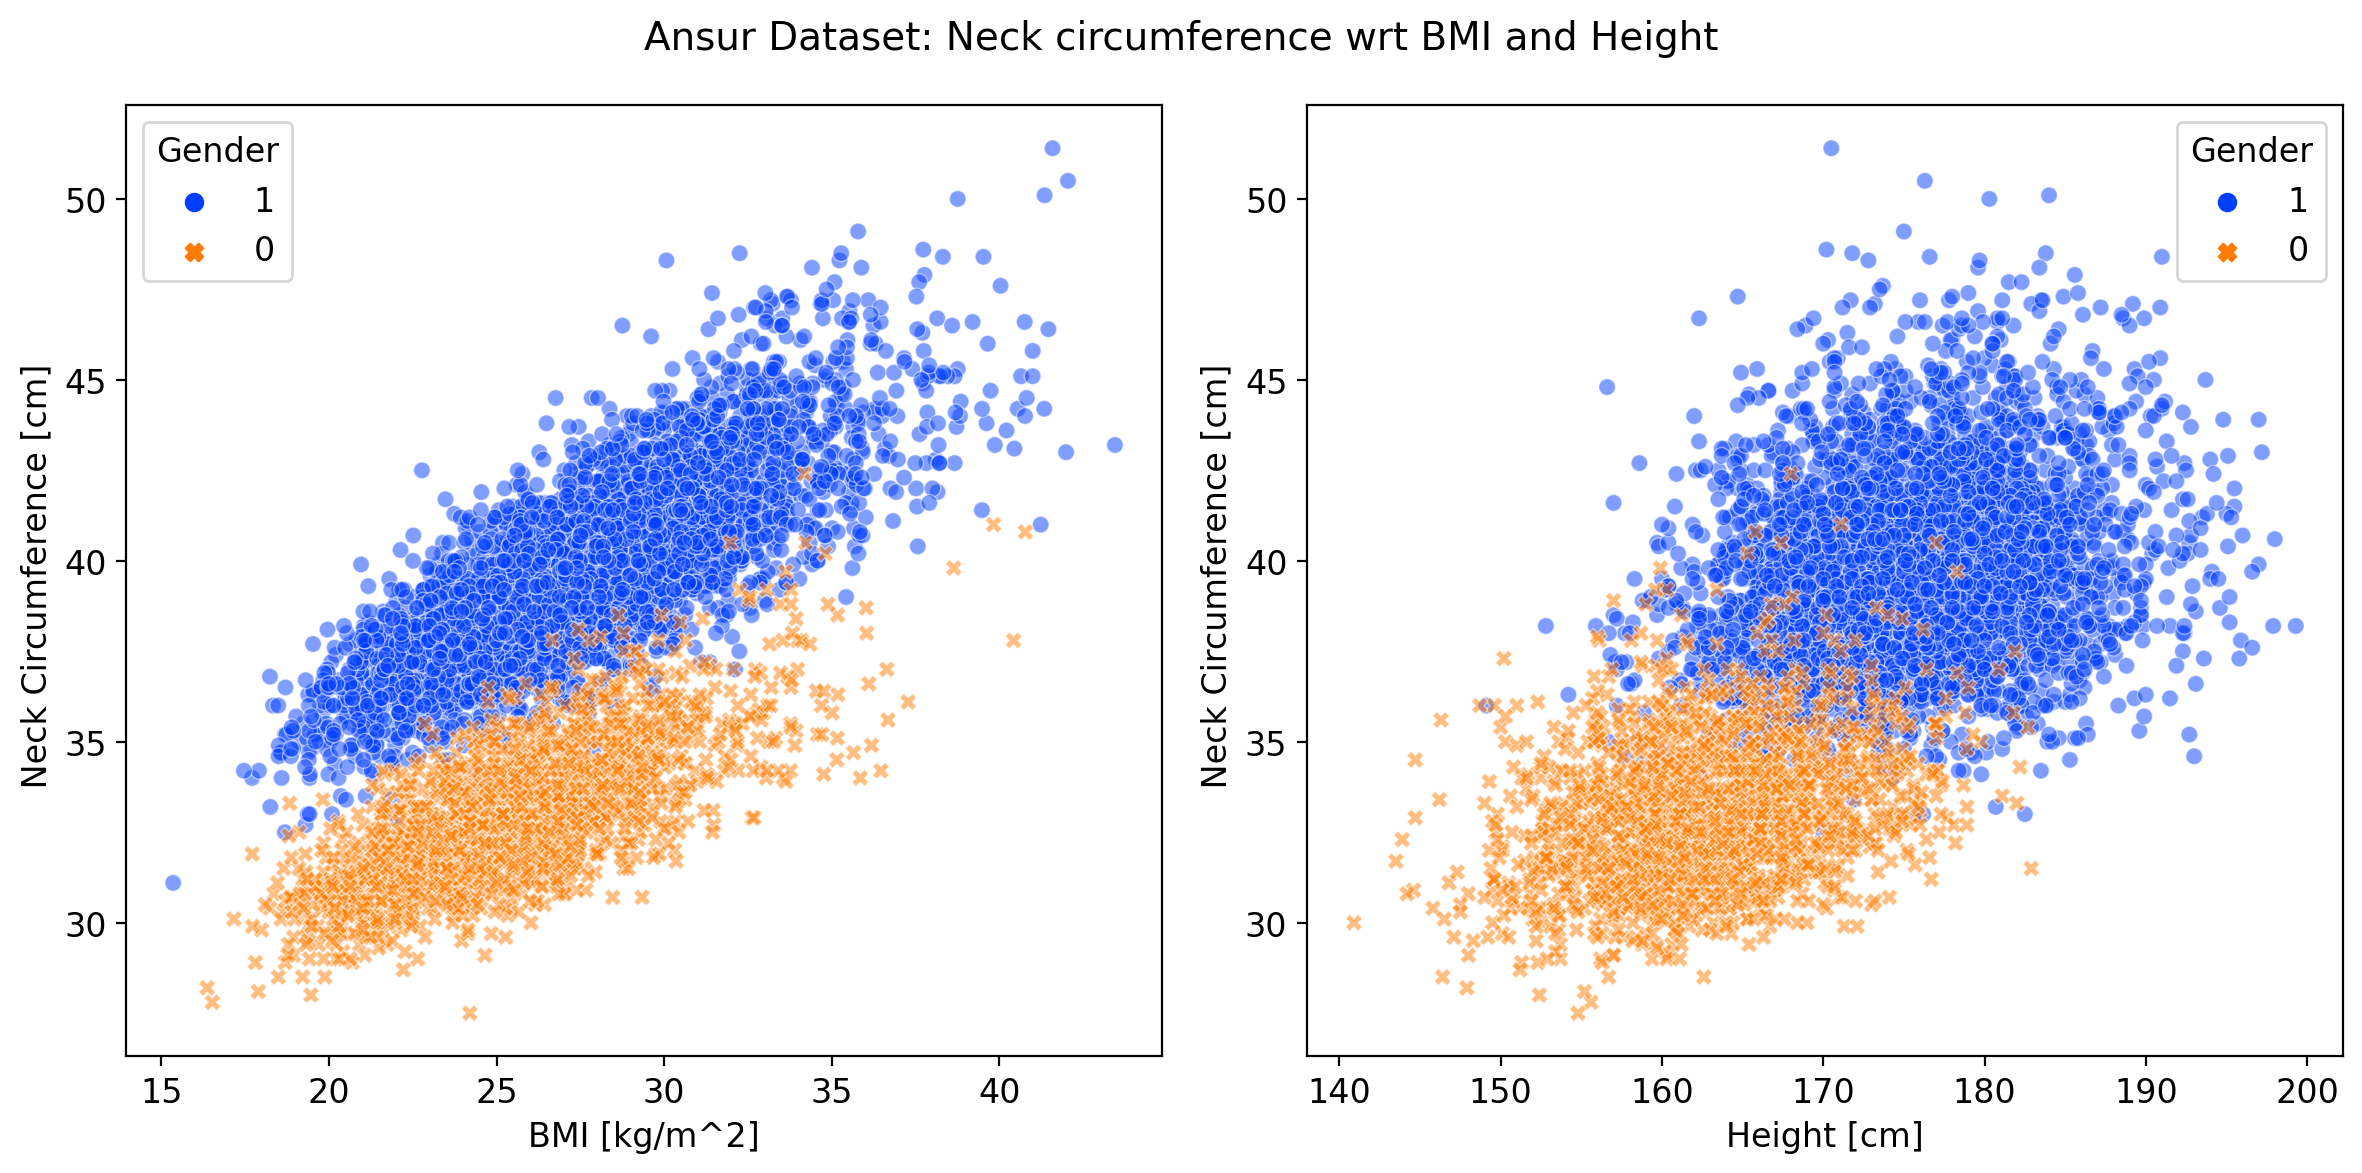

In [4]:
fig, axes = plt.subplots(1,2, figsize=(12, 6)) # male 1 and female 0
sns.scatterplot(ax = axes[0], data=subset,y="neckcircumference", x="BMI", hue="Gender", style="Gender",palette="bright", alpha = 0.5)
sns.scatterplot(ax = axes[1], data=subset,y="neckcircumference", x="stature", hue="Gender",style="Gender",palette="bright", alpha = 0.5)
axes[1].set_xlabel("Height [cm]");axes[1].set_ylabel(" Neck Circumference [cm]")
axes[0].set_xlabel("BMI [kg/m^2]");axes[0].set_ylabel(" Neck Circumference [cm]")
fig.suptitle("Ansur Dataset: Neck circumference wrt BMI and Height", fontsize = 14)
plt.tight_layout()

## The Model

Model and Prior Distribution: 

$$ Female = 0 $$
$$ Male = 1  $$

-----

$$ \alpha_{[0,1]} \sim Normal(34,5) \newline $$
$$ \beta_{[0,1]} \sim Normal(0,1) \newline $$
$$ \gamma_{[0,1]} \sim Normal(0,1) \newline $$
$$ \sigma \sim Uniform(0,10) \newline $$

-----

$$\Large{\mu_{i} =\alpha_{[0,1]} + \beta_{[0,1]} (H - \bar H) +  \gamma_{[0,1]} (BMI - \overline{BMI})} $$


In [5]:
with pm.Model() as model:
    
    # Height & bmi 
    alpha = pm.Normal("alpha", 34,5,shape=2)
    beta = pm.Normal("beta", 0,1,shape=2)
    gamma = pm.Normal("gamma", 0,5,shape=2)
    sigma = pm.Uniform("sigma", 0,10)
    mu = pm.Deterministic("mu", alpha[s_index] + beta[s_index] * (ansur_height - height_mean) + gamma[s_index] * (ansur_bmi - bmi_mean))
    neck_circ = pm.Normal("neck_circ", mu, sigma, observed = ansur_circ)  
    idata = pm.sample(draws=1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


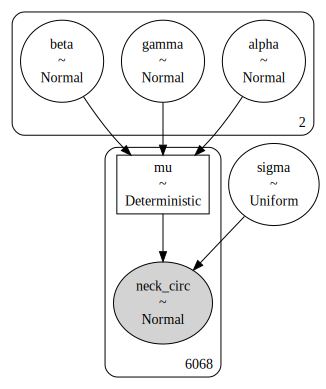

In [6]:
pm.model_to_graphviz(model)

In [7]:
az.summary(idata, var_names=["alpha", "beta", "gamma", "sigma"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]  34.219  0.054  34.116   34.320      0.001    0.001    4547.0   
alpha[1]  39.096  0.026  39.049   39.145      0.000    0.000    4999.0   
beta[0]    0.076  0.005   0.067    0.085      0.000    0.000    4647.0   
beta[1]    0.073  0.003   0.067    0.079      0.000    0.000    5312.0   
gamma[0]   0.395  0.009   0.378    0.412      0.000    0.000    6632.0   
gamma[1]   0.508  0.005   0.497    0.518      0.000    0.000    5689.0   
sigma      1.398  0.013   1.375    1.424      0.000    0.000    5762.0   

          ess_tail  r_hat  
alpha[0]    3256.0    1.0  
alpha[1]    2723.0    1.0  
beta[0]     3150.0    1.0  
beta[1]     3307.0    1.0  
gamma[0]    3144.0    1.0  
gamma[1]    3180.0    1.0  
sigma       2880.0    1.0

In [8]:
with model: 
    prior_samples = pm.sample_prior_predictive(1000) # sample the priors
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42)  # sample the posterior

Sampling: [alpha, beta, gamma, neck_circ, sigma]
Sampling: [neck_circ]


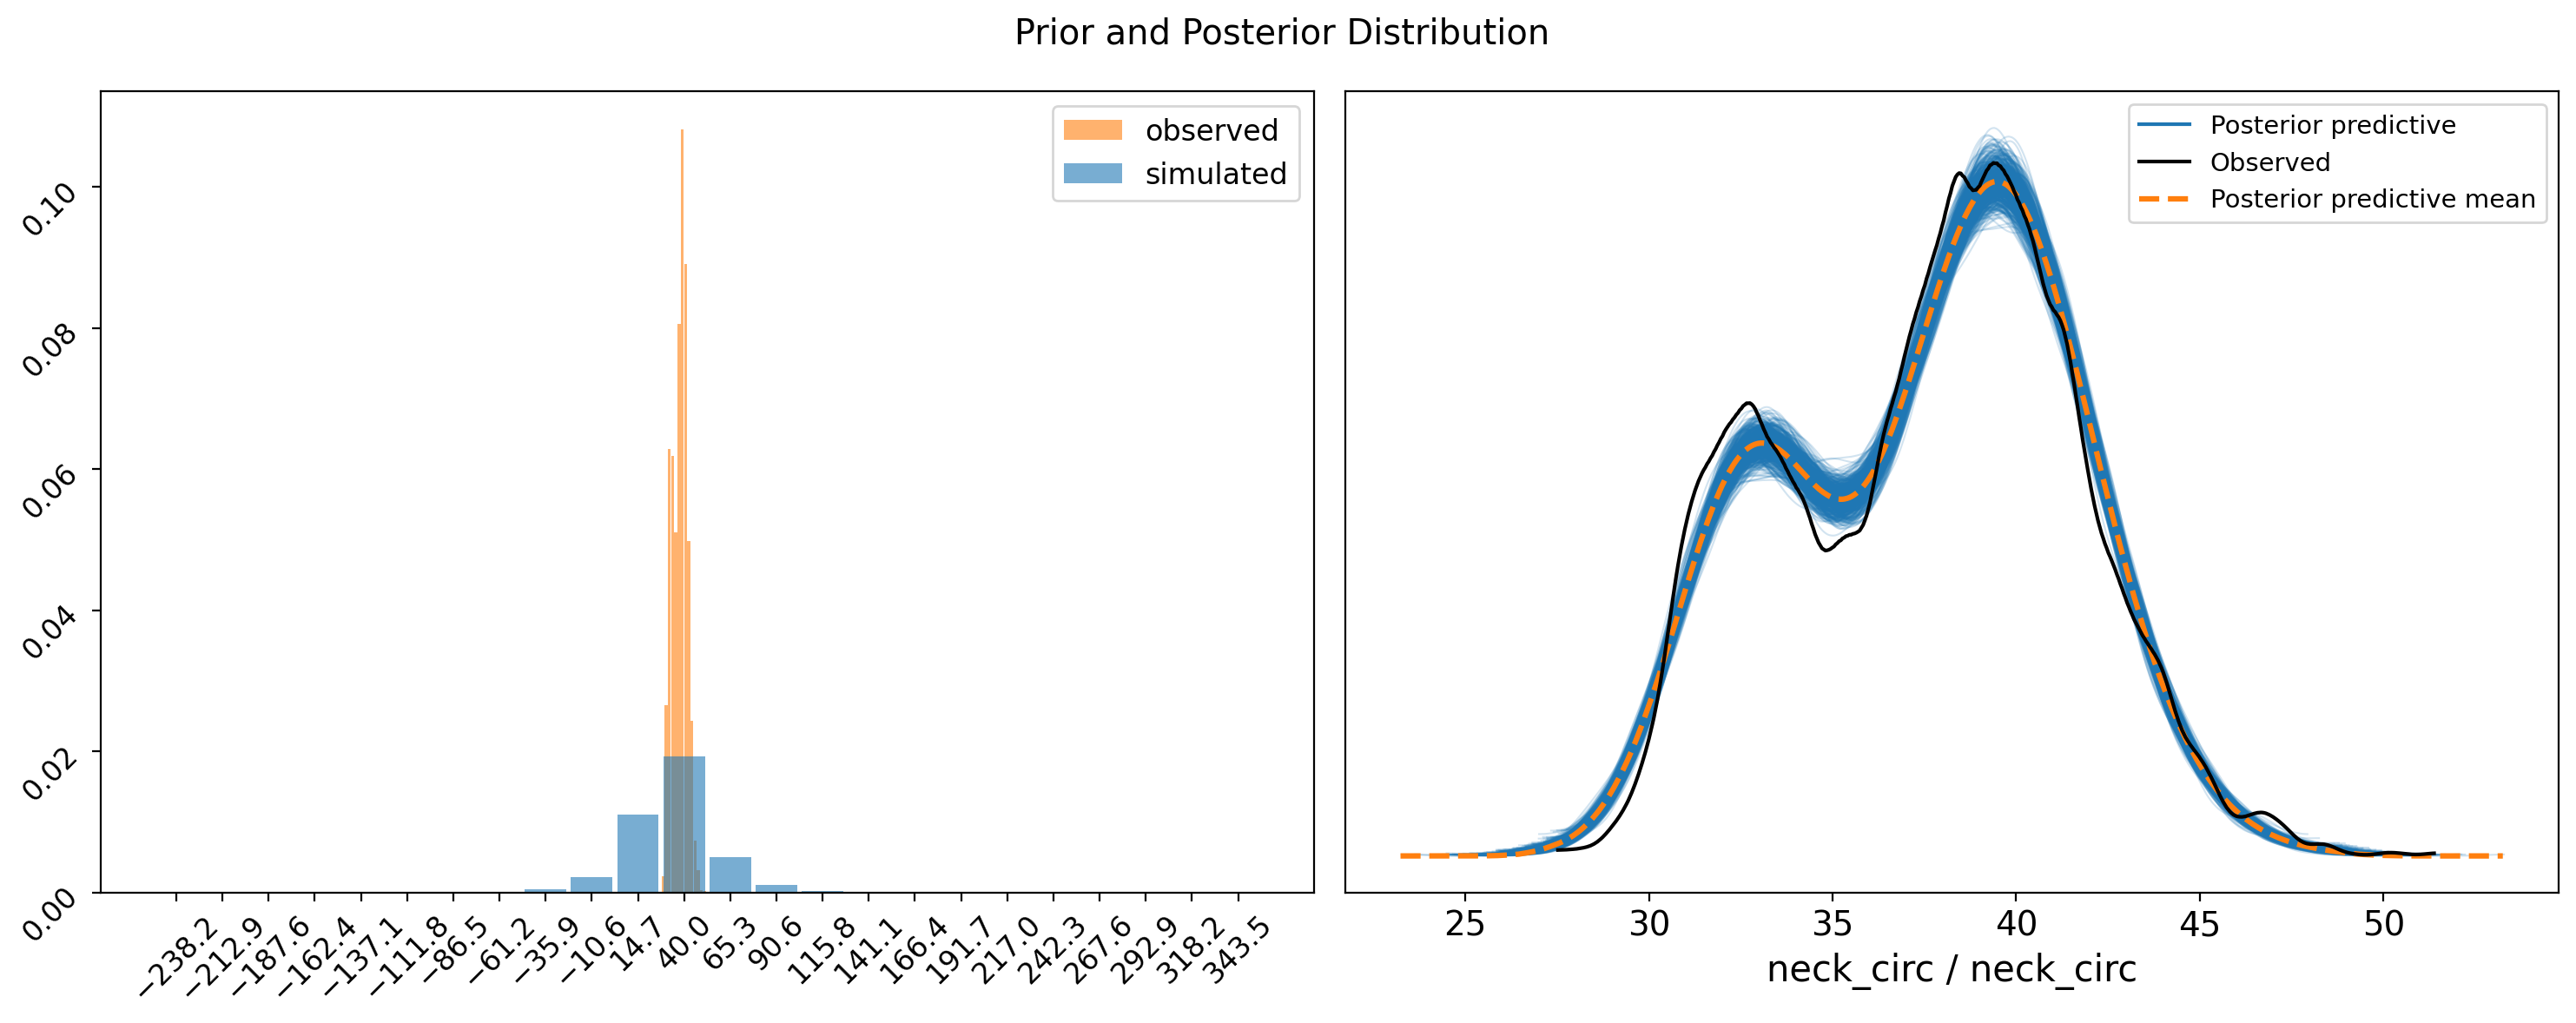

In [9]:
# plot 
fig, ax = plt.subplots(1,2,figsize=(15, 6))
fig.suptitle("Prior and Posterior Distribution ")
# plt.xticks(rotation=45);
ax[0].tick_params(labelrotation=45)
az.plot_dist(ansur_circ,kind="hist", color="C1", hist_kwargs=dict(alpha=0.6),label="observed",ax= ax[0])
az.plot_dist(prior_samples.prior_predictive["neck_circ"],kind="hist",hist_kwargs=dict(alpha=0.6),label="simulated",ax= ax[0])
az.plot_ppc(idata,var_names = "neck_circ", num_pp_samples=600, ax = ax[1])
fig.tight_layout()

In [10]:
idata_df = idata.to_dataframe()

To visualize the contribution of weight and height to the neck circumference with the mean posterior line. 
An increment in 10 cm in height contributes 0.76 cm in neck circumference for females and 0.72cm for males.
An increment of 1 BMI unit, corresponds to 0.39 cm for females and 0.5 cm for males in neck circumference. 

In [11]:
trace = az.extract(idata)

In [12]:
bmi_female = subset[subset['Gender'] == '0']['BMI']
bmi_male = subset[subset['Gender'] == '1']['BMI']
height_female = subset[subset['Gender'] == '0']['stature']
height_male = subset[subset['Gender'] == '1']['stature']

In [13]:
bmi_seq_female = np.linspace(bmi_female.min(), bmi_female.max(),4000);height_seq_female = np.linspace(height_female.min(), height_female.max(),4000)
bmi_seq_male = np.linspace(bmi_male.min(), bmi_male.max(),4000);height_seq_male = np.linspace(height_male.min(), height_male.max(),4000)

mu_pred_female = np.zeros((len(bmi_seq_female),trace.sizes["sample"]))
mu_pred_male = np.zeros((len(bmi_seq_male),trace.sizes["sample"]))
for i, (w_f,h_f,w_m,h_m) in enumerate(zip(bmi_seq_female, height_seq_female,bmi_seq_male, height_seq_male)):
    mu_pred_female[i] = trace["alpha"][0] + trace["gamma"][0] * (w_f- bmi_mean)  + trace["beta"][0] * (h_f - height_mean)
    mu_pred_male[i] = trace["alpha"][1] + trace["gamma"][1] * (w_m- bmi_mean)  + trace["beta"][1] * (h_m - height_mean)

circ_rng = np.random.default_rng(2971)
post_samples_female = [];post_samples_male = []
for _ in range(1000):  # number of samples from the posterior
    i = circ_rng.integers(len(trace))
    mu_pr_female = trace["alpha"][0][i].item(0) + trace["gamma"][0][i].item(0) * (bmi_seq_female - bmi_mean) + trace["beta"][0][i].item(0) * (height_seq_female - height_mean)
    mu_pr_male = trace["alpha"][1][i].item(0) + trace["gamma"][1][i].item(0) * (bmi_seq_male - bmi_mean) + trace["beta"][1][i].item(0) * (height_seq_male - height_mean)
    sigma_pred = trace["sigma"][i]
    post_samples_female.append(circ_rng.normal(mu_pr_female, sigma_pred))
    post_samples_male.append(circ_rng.normal(mu_pr_male, sigma_pred))

c:\Users\chiarar\Anaconda3\envs\quarto-manuscript\lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\Users\chiarar\Anaconda3\envs\quarto-manuscript\lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\Users\chiarar\Anaconda3\envs\quarto-manuscript\lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, 

Text(0, 0.5, 'Neck Circumference [cm]')

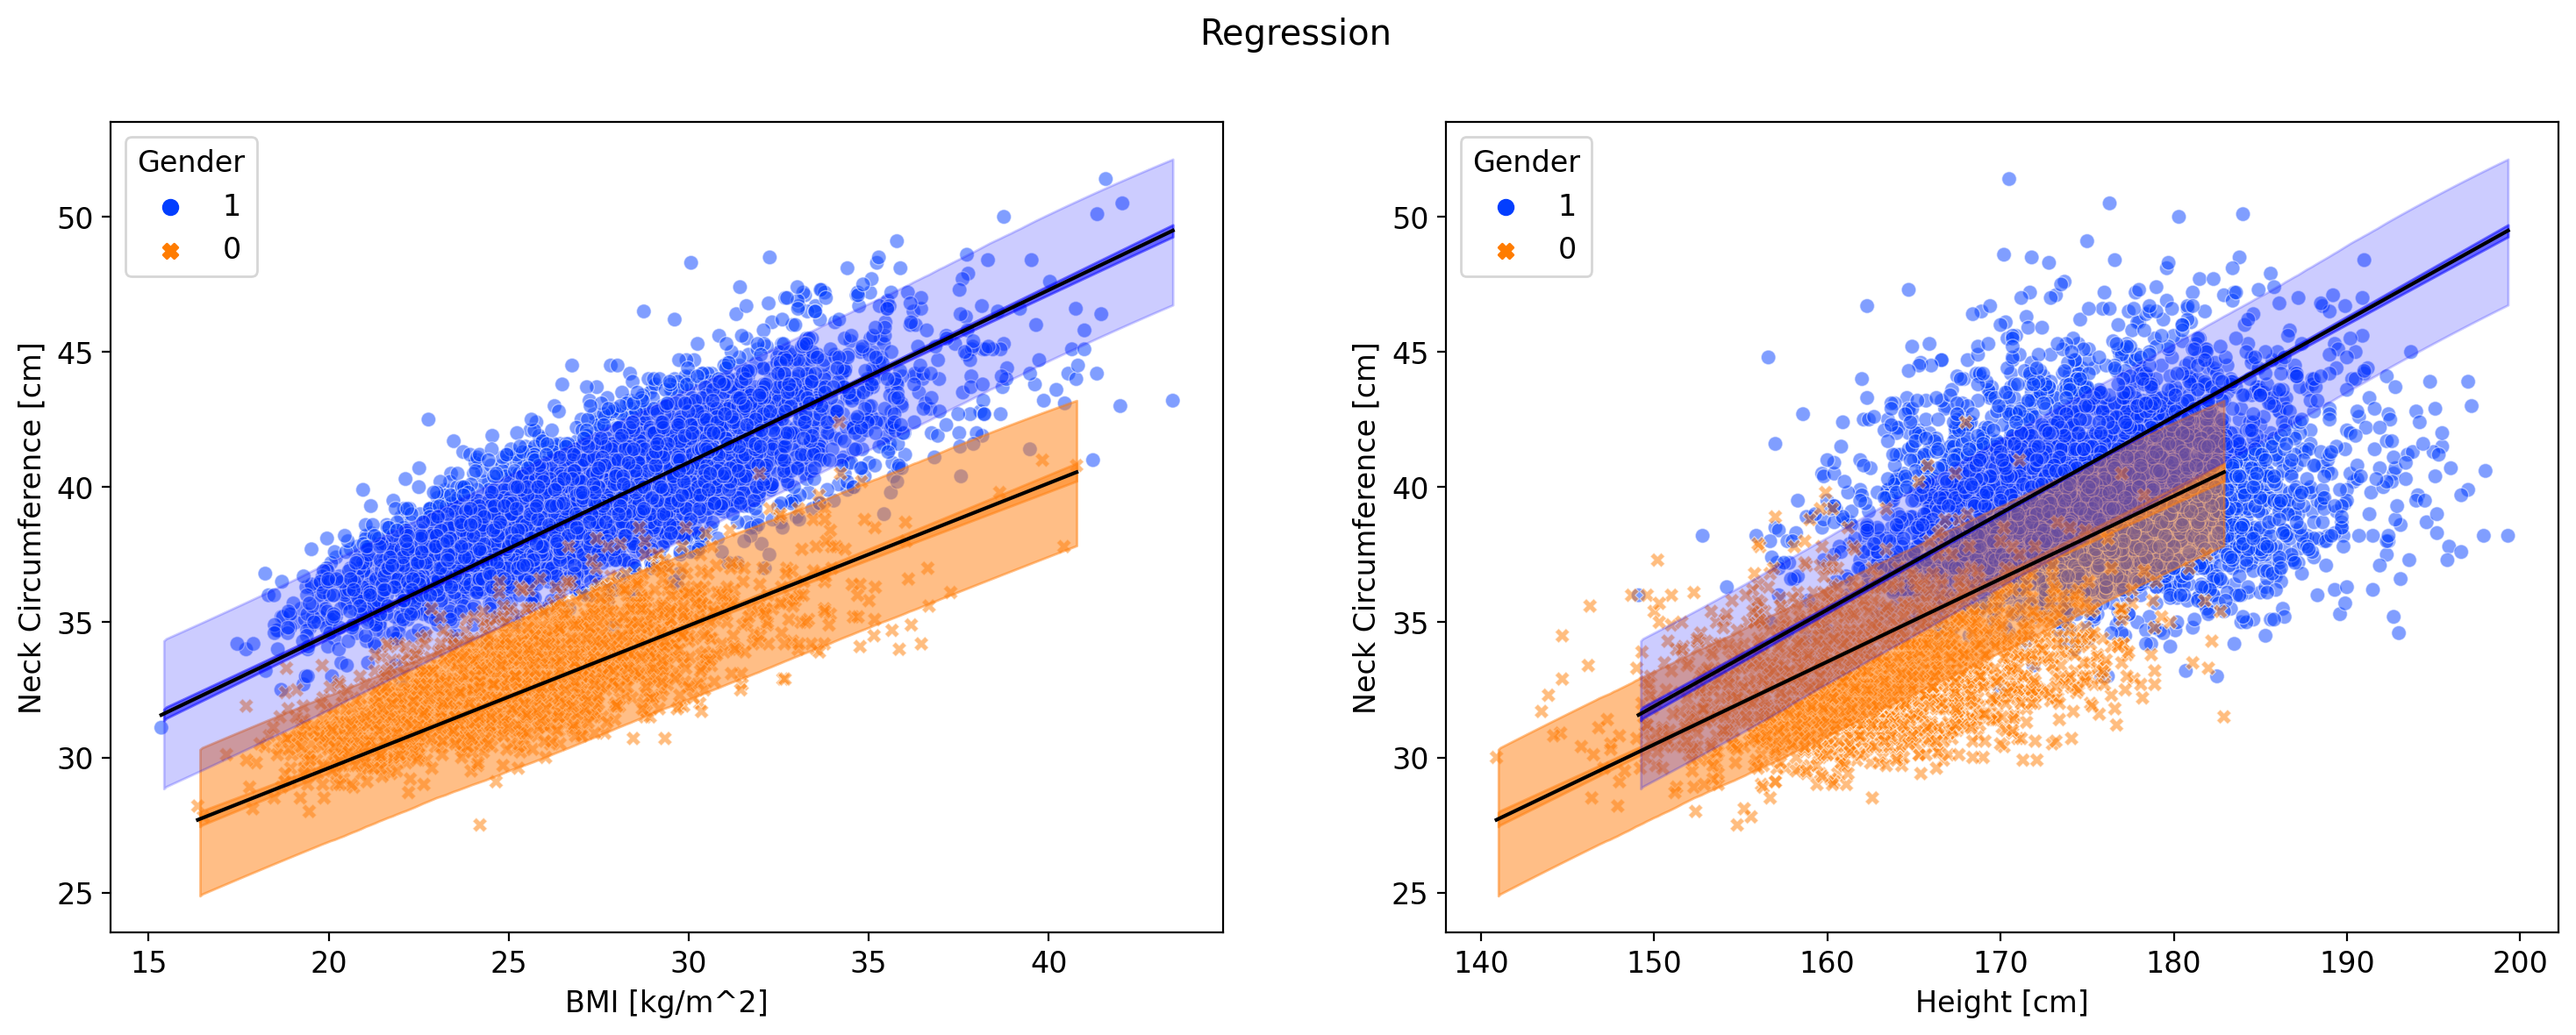

In [14]:
# PLOTS
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(18, 6))
fig.suptitle("Regression")    
sns.scatterplot(data=subset,y="neckcircumference", x="BMI", hue="Gender", alpha = 0.5, ax= ax0, style="Gender",palette="bright")
# BMI
az.plot_hdi(bmi_seq_female, mu_pred_female.T, hdi_prob=0.95,ax=ax0)
az.plot_hdi(bmi_seq_female, np.array(post_samples_female), ax=ax0, hdi_prob=0.95)
ax0.plot(bmi_seq_female,mu_pred_female.mean(1), "k")
az.plot_hdi(bmi_seq_male, mu_pred_male.T, hdi_prob=0.95,ax= ax0, color="blue")
az.plot_hdi(bmi_seq_male, np.array(post_samples_male), ax=ax0, hdi_prob=0.95,color="blue",fill_kwargs={"alpha": .2})
ax0.plot(bmi_seq_male,mu_pred_male.mean(1), "k")
# Height 
sns.scatterplot(data=subset,y="neckcircumference", x="stature", hue="Gender", alpha = 0.5,ax= ax1, style="Gender",palette="bright")
az.plot_hdi(height_seq_female, mu_pred_female.T, hdi_prob=0.95,ax= ax1)
az.plot_hdi(height_seq_female, np.array(post_samples_female), ax=ax1, hdi_prob=0.95)
ax1.plot(height_seq_female,mu_pred_female.mean(1), "k")
az.plot_hdi(height_seq_male, mu_pred_male.T, hdi_prob=0.95,color="blue",ax=ax1)
az.plot_hdi(height_seq_male, np.array(post_samples_male), ax=ax1, hdi_prob=0.95,color="blue",fill_kwargs={"alpha": .2})
ax1.plot(height_seq_male,mu_pred_male.mean(1), "k")

ax1.set_xlabel("Height [cm]"); ax1.set_ylabel("Neck Circumference [cm]")
ax0.set_xlabel("BMI [kg/m^2]");ax0.set_ylabel("Neck Circumference [cm]")

##### Posterior Mean

Plot the mean posterior for a sample of 1000 female and males

Mean for female: 32.924 cm
Mean for male: 39.895 cm

PLOT 2:
Mean of the difference: 6.971 cm


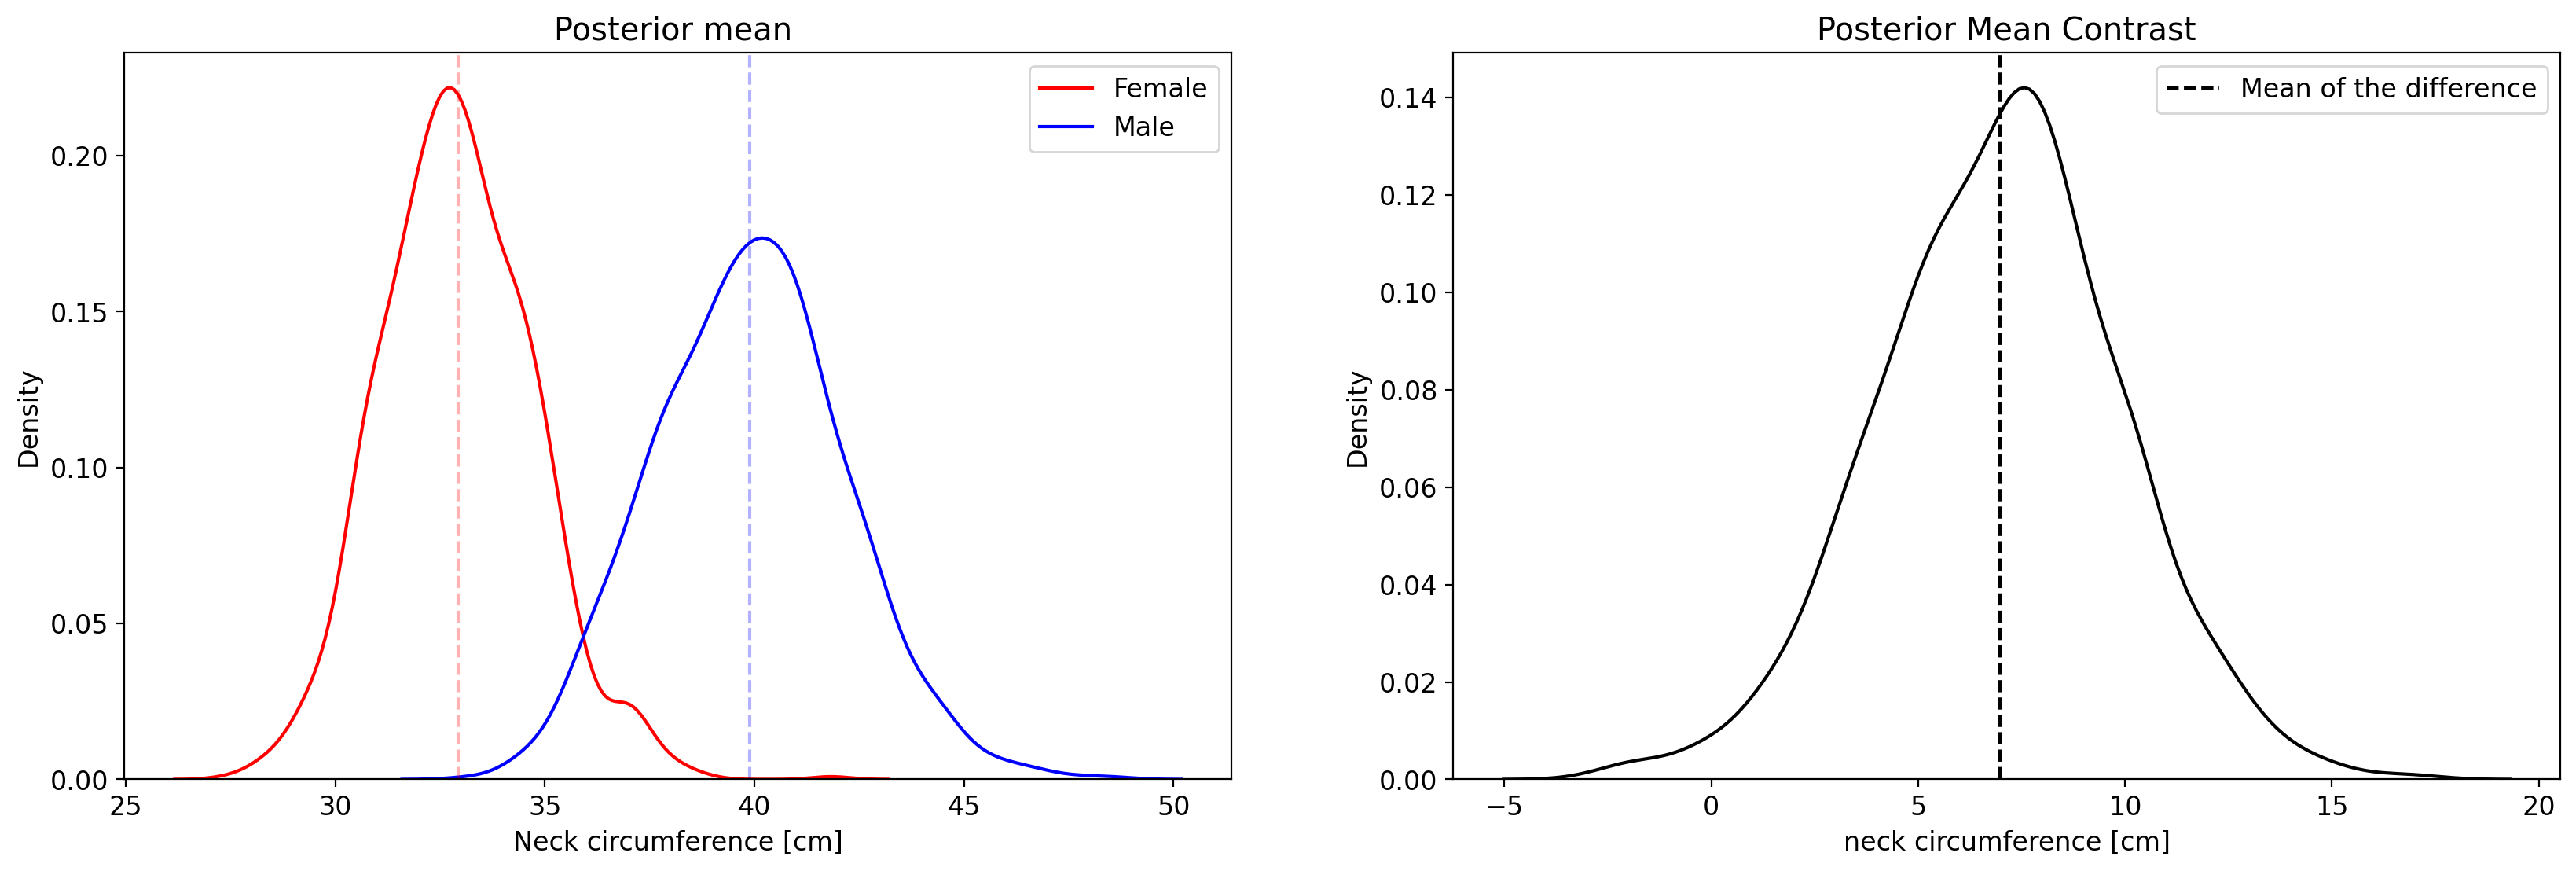

In [15]:
mu_female = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)][:1000] + idata_df[("posterior", "gamma[0]", 0)][:1000] * (bmi_female[:1000]  - bmi_mean) + idata_df[("posterior", "beta[0]", 0)][:1000] * (height_female[:1000]  - height_mean) ), size =1000 )
mu_male = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)][:1000] + idata_df[("posterior", "gamma[1]", 1)][:1000] * (bmi_male[:1000] - bmi_mean) + idata_df[("posterior", "beta[1]", 1)][:1000] * (height_male[:1000] - height_mean) ), size =1000 )
f, ax = plt.subplots(1,2 , figsize=(20, 6))
ax[0].set_title("Posterior mean ")
ax[0].set_xlabel("Neck circumference [cm]")
sns.kdeplot( mu_female, color="red", ax=ax[0], label= "Female")
sns.kdeplot( mu_male , color="blue", ax=ax[0], label= "Male")
ax[0].axvline(x=(np.mean(mu_female)), linestyle="dashed", color="red",alpha=0.3)
ax[0].axvline(x=(np.mean(mu_male)), linestyle="dashed", color="blue",alpha=0.3)
print(f"Mean for female:", np.round(np.nanmean(mu_female),3), "cm")
print(f"Mean for male:", np.round(np.nanmean(mu_male),3), "cm")
ax[1].set_title("Posterior Mean Contrast")
ax[1].set_xlabel("neck circumference [cm]")
mu_contrast = mu_male - mu_female
sns.kdeplot(mu_contrast,color='black' ,ax=ax[1])

kde_x, kde_y = ax[1].lines[0].get_data()
ax[1].axvline(x=np.nanmean(mu_contrast), linestyle="dashed", color="black", label= "Mean of the difference")
ax[0].legend(); ax[1].legend();
print(f"\nPLOT 2:")
print(f"Mean of the difference:", np.round(np.nanmean(mu_contrast),3), "cm")

##### Posterior Distribution

Proportion above zero: 0.981
Proportion below zero: 0.019


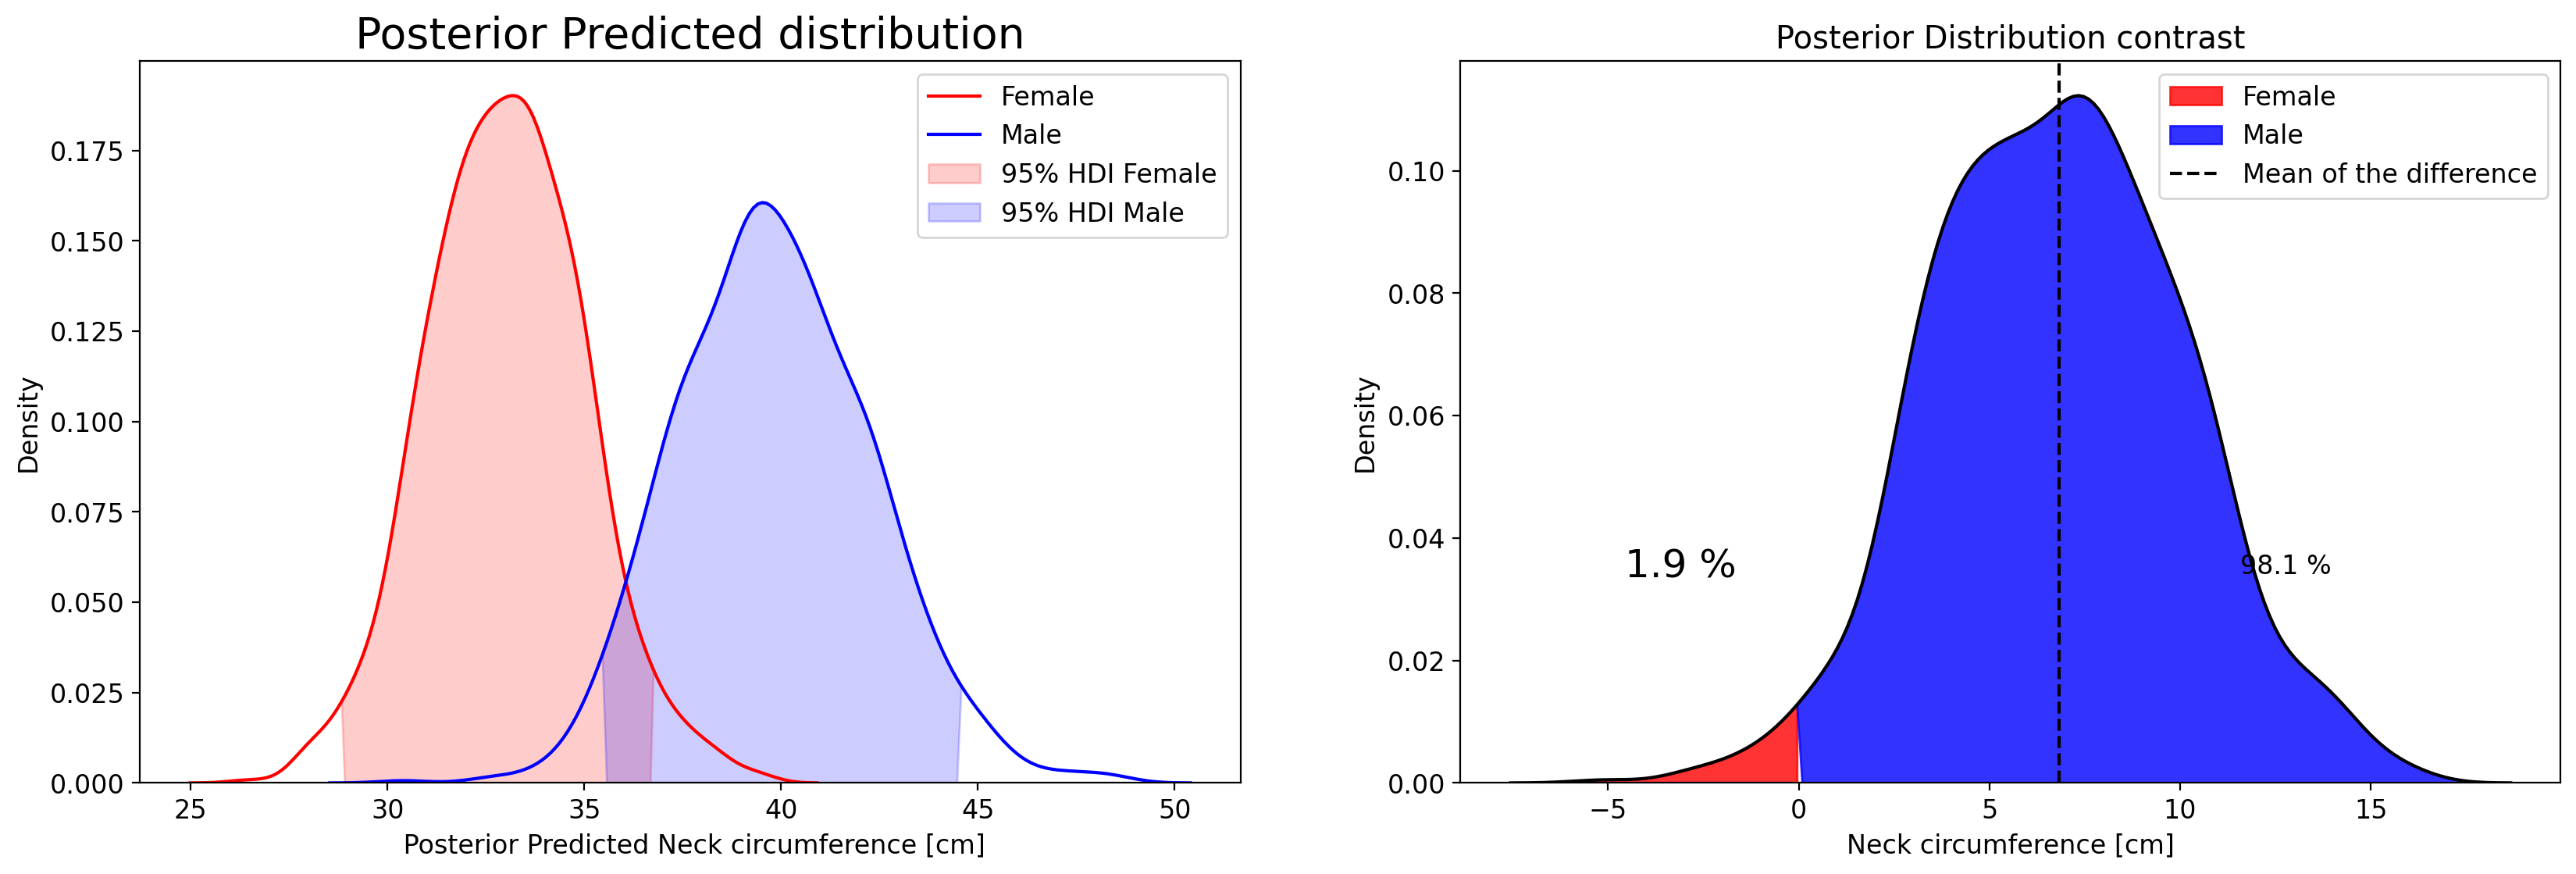

In [16]:
#| label: fig-contrast-distribution
#| fig-cap: "Posterior Distribution Contrast Neck Circumference"
# posterior W distributions
f, ax = plt.subplots(1,2, figsize=(20, 6))
N0 = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (bmi_female[:1000] - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (height_female[:1000] - height_mean) ), scale =idata_df[("posterior", "sigma")] )
N1 = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (bmi_male[:1000] - bmi_mean)   + idata_df[("posterior", "beta[1]", 1)] * (height_male[:1000] - height_mean) ),   scale =idata_df[("posterior", "sigma")] )
sns.kdeplot(N0, color="red", label="Female", ax=ax[0])
sns.kdeplot(N1, color="blue", label="Male", ax=ax[0])

# HDI
#-----------------------
kde_female_x, kde_female_y = ax[0].lines[0].get_data()
low_female_int, high_female_int = az.hdi(N0[~np.isnan(N0)], hdi_prob=.95)
ax[0].fill_between(kde_female_x, kde_female_y, where=(low_female_int< kde_female_x)& ( kde_female_x <high_female_int), color="red", alpha= 0.2, label="95% HDI Female",interpolate=True)
kde_male_x, kde_male_y = ax[0].lines[1].get_data()
low_male_int, high_male_int = az.hdi(N1[~np.isnan(N1)])
ax[0].fill_between(kde_male_x, kde_male_y, where=(low_male_int< kde_male_x)& ( kde_male_x <high_male_int), color="blue", alpha= 0.2, label="95% HDI Male",interpolate=True)
#------------------------------
ax[0].set(xlabel=" Posterior Predicted Neck circumference [cm]"); ax[0].set_title("Posterior Predicted distribution", fontsize=20)
ax[0].legend()

# contrast
N_contrast = N1 - N0
ax[1].set_title("Posterior Distribution contrast")
sns.kdeplot(N_contrast, color="black", ax=ax[1])
kde_x, kde_y = ax[1].lines[0].get_data()
ax[1].fill_between(kde_x, kde_y, where=kde_x < 0, color="red", alpha= 0.8, label="Female",interpolate=True)
ax[1].fill_between(kde_x, kde_y, where=kde_x > 0, color="blue", alpha= 0.8,label="Male", interpolate=True)
ax[1].set(xlabel="Neck circumference [cm]")
# proportion above zero
print(f"Proportion above zero: {np.round(sum((N_contrast[~np.isnan(N_contrast)]) > 0)  / len(N_contrast[~np.isnan(N_contrast)]),3)}")
# proportion below zero
print(f"Proportion below zero: {np.round(sum((N_contrast[~np.isnan(N_contrast)]) < 0)  / len(N_contrast[~np.isnan(N_contrast)]),3)}")
ax[1].axvline(x= np.nanmean(N_contrast), linestyle="dashed", color="black", label= "Mean of the difference")
perc = np.round(sum((N_contrast[~np.isnan(N_contrast)]) > 0)  / len(N_contrast[~np.isnan(N_contrast)]),3)
ax[1].text(0.75, 0.3, "%.1f %%"%(perc*100), horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
ax[1].text(0.2, 0.3, "%.1f %%"%((1-perc)*100), horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize = 18)

ax[1].legend()

Create a sample of 50 individual and plot the posterior contrast on height and BMI. 

Contrast (Male - Female) for individual with average height or BMI for 50 samples.

Fixed Height - BMI varies 14 to 44 kg/m^2

Fixed BMI - Height varies 120-190 

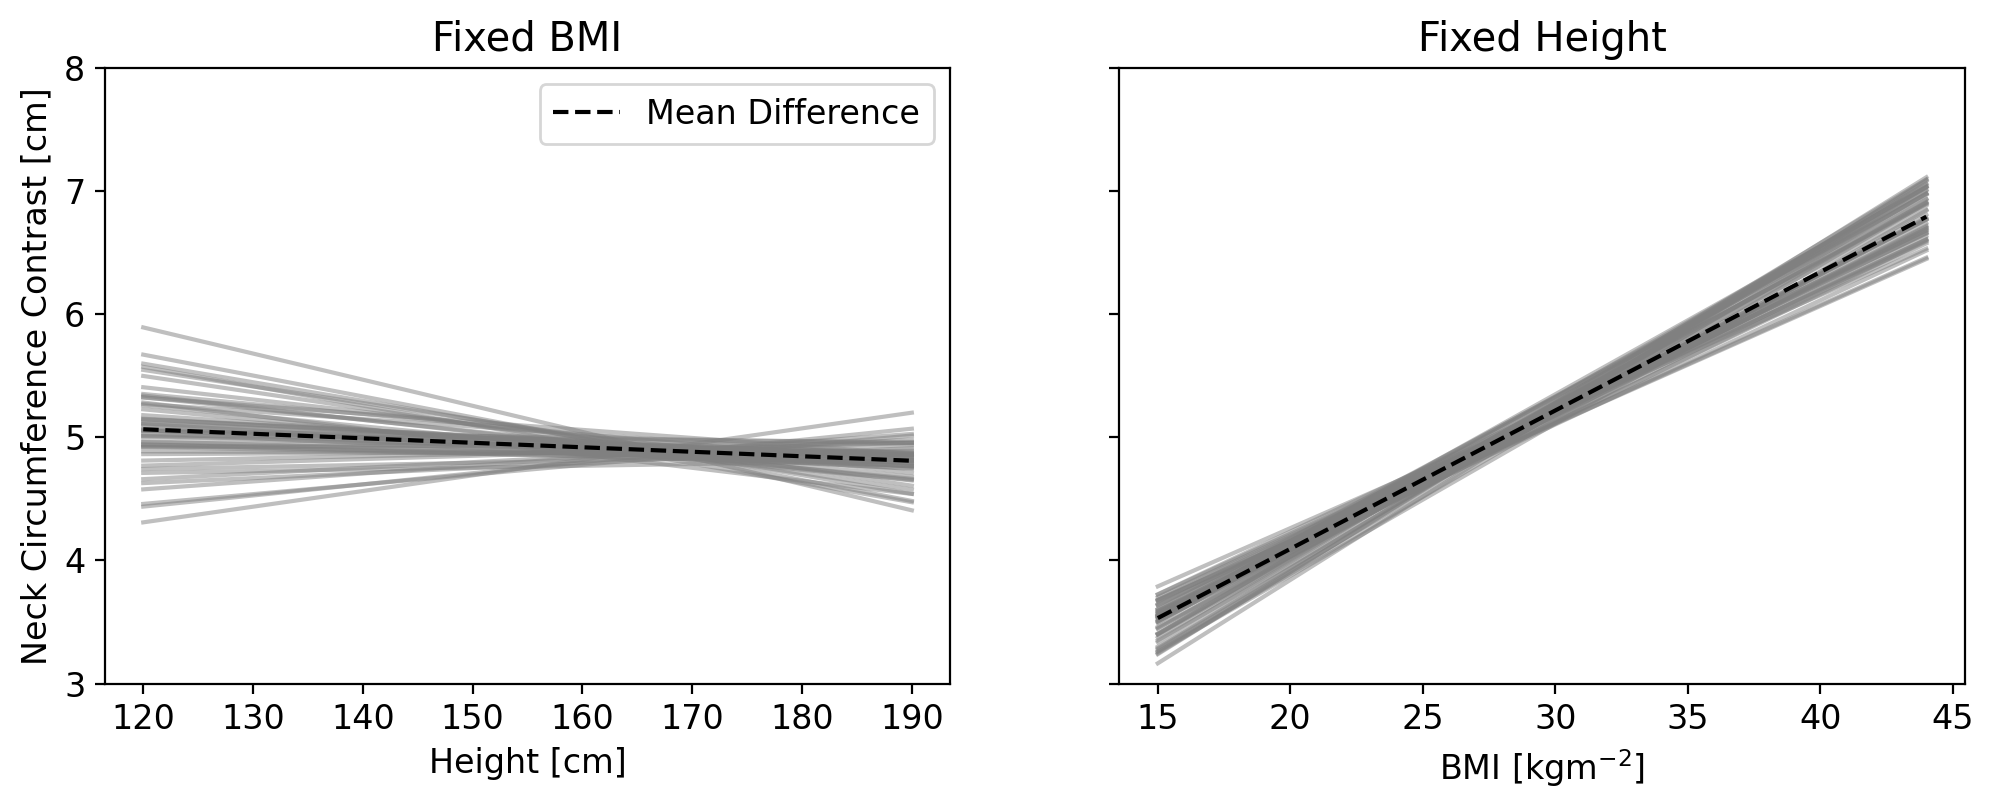

In [17]:
#| label: fig-contrast
#| fig-cap: "Posterior Contrast Neck Circumference"
bmi_seq = np.linspace(15, 44, num=50)
hseq = np.linspace(120, 190, num=50)
# initialize dataframes
mu_F_bmi = np.zeros((len(idata_df), len(bmi_seq)))
mu_M_bmi = np.zeros((len(idata_df), len(bmi_seq)))
# Fill female and male predictions
for i, (x, h) in enumerate(zip(bmi_seq,hseq)):
    mu_F_bmi[:, i] = idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (x - bmi_mean)  
    mu_M_bmi[:, i] = idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (x - bmi_mean) 
mu_contrast_MF_bmi= mu_M_bmi - mu_F_bmi

# initialize dataframes
mu_F_height = np.zeros((len(idata_df), len(bmi_seq)))
mu_M_height = np.zeros((len(idata_df), len(bmi_seq)))
# Fill female and male predictions
for i, (x, h) in enumerate(zip(bmi_seq,hseq)):
    mu_F_height[:, i] = idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "beta[0]", 0)] * (h - height_mean) 
    mu_M_height[:, i] = idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "beta[1]", 1)] * (h - height_mean) 
mu_contrast_MF_height= mu_M_height - mu_F_height

f, ((ax0, ax1)) = plt.subplots(1, 2,figsize=(12, 4),sharey=True)
#f.suptitle("Posterior contrast M-F")
for i in range(50):
    ax1.plot(bmi_seq, mu_contrast_MF_bmi[i, :], color="gray", alpha=0.5)
    ax0.plot(hseq, mu_contrast_MF_height[i, :], color="gray", alpha=0.5)
        
ax0.plot(hseq, mu_contrast_MF_height.mean(axis=0), color="black", linestyle='--', label ="Mean Difference")
ax0.set(xlabel="Height [cm]", ylabel="Neck Circumference Contrast [cm]")
ax1.plot(bmi_seq, mu_contrast_MF_bmi.mean(axis=0), color="black", linestyle='--')
ax1.set(xlabel="BMI [kgm$^{-2}$]");ax1.set_title("Fixed Height");ax0.set_title("Fixed BMI");ax0.set_ylim([3,8])
ax0.legend()
# f.tight_layout()
# plt.savefig("images/Neck_circumference-contrast.png")

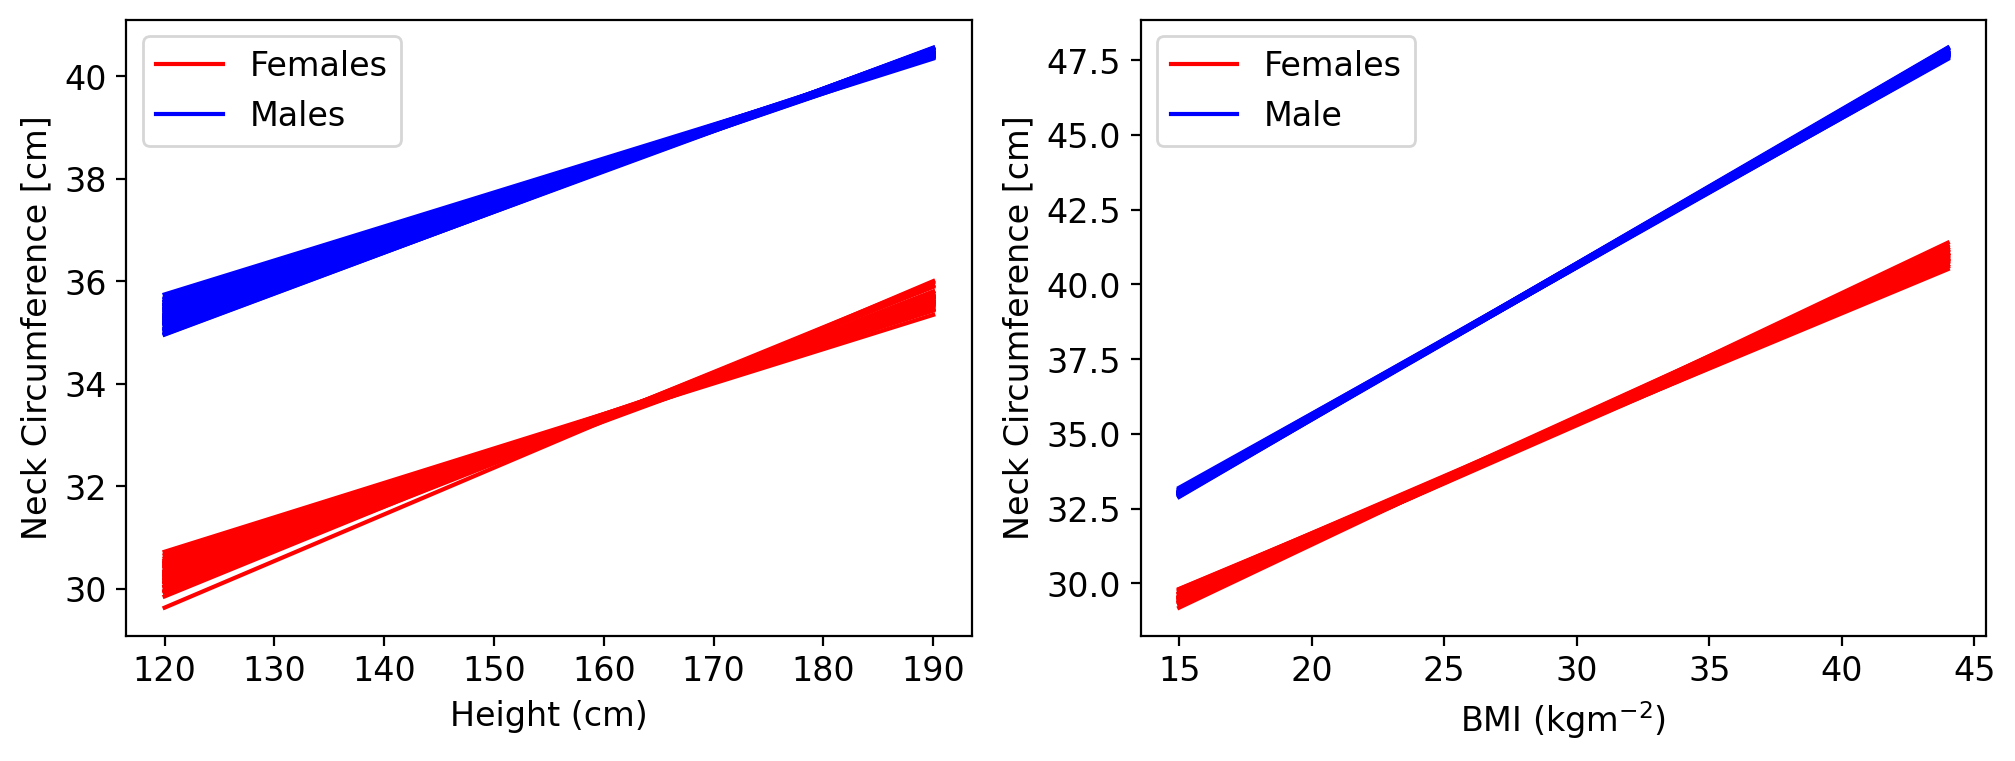

In [18]:
f, ((ax2,ax3)) = plt.subplots(1, 2, figsize=(12, 4))
for i in range(50):
    if i == 0:
        ax2.plot(hseq, mu_F_height[i, :], color="red", label="Females")
        ax2.plot(hseq, mu_M_height[i, :], color="blue", label="Males")
    else:
        ax2.plot(hseq, mu_F_height[i, :], color="red")
        ax2.plot(hseq, mu_M_height[i, :], color="blue")
ax2.set(xlabel="Height (cm)", ylabel="Neck Circumference [cm]")
ax2.legend()
for i in range(50):
    if i == 0:
        ax3.plot(bmi_seq, mu_F_bmi[i, :], color="red", label="Females")
        ax3.plot(bmi_seq, mu_M_bmi[i, :], color="blue", label="Male")
    else:
        ax3.plot(bmi_seq, mu_F_bmi[i, :], color="red")
        ax3.plot(bmi_seq, mu_M_bmi[i, :], color="blue")
ax3.set(xlabel="BMI (kgm$^{-2}$)", ylabel="Neck Circumference [cm]")
ax3.legend()

##### Posterior predictive plot

In [19]:
with model:
    ansur_reg_ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "neck_circ"])

mu_mean = ansur_reg_ppc.posterior_predictive["mu"].mean(dim=["chain", "draw"])
mu_PI = az.hdi(ansur_reg_ppc.posterior_predictive["mu"], 0.95)

neck_sim = ansur_reg_ppc.posterior_predictive["neck_circ"].mean(dim=["chain", "draw"])
neck_PI = az.hdi(ansur_reg_ppc.posterior_predictive["neck_circ"], 0.95)

Sampling: [neck_circ]


In [20]:
ansur_circ_std =  (ansur_circ.values -  ansur_circ.values.mean())/  ansur_circ.values.std()
neck_sim_std =  (neck_sim.values -  neck_sim.values.mean())/  neck_sim.values.std()

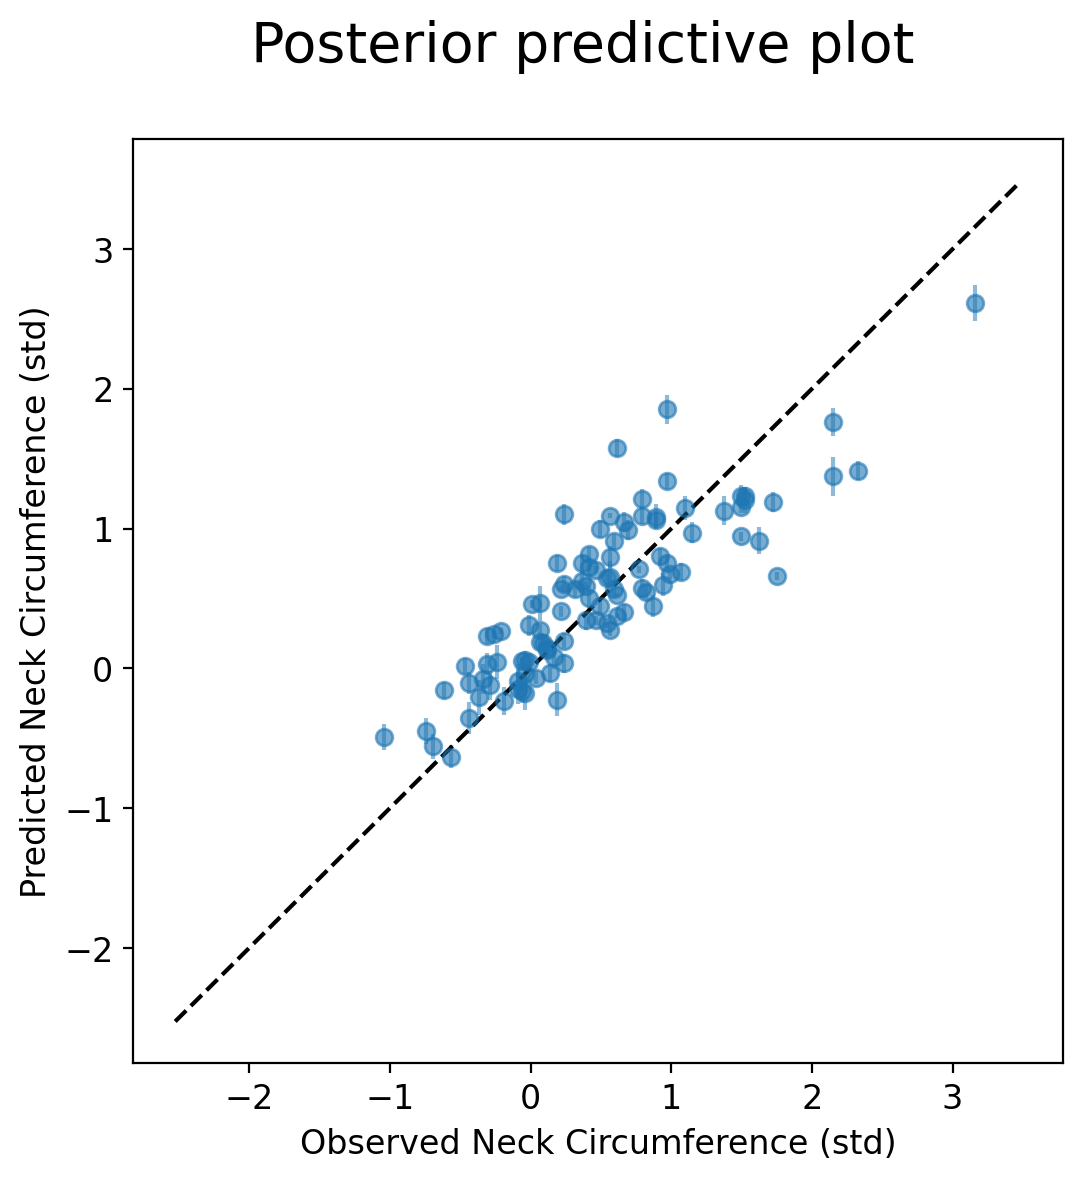

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle("Posterior predictive plot", fontsize= 20)
plt.errorbar(
    ansur_circ_std[:100],
    neck_sim_std[:100],
    alpha=0.5,
    yerr=np.abs(np.array(neck_sim) - mu_PI.min(dim="hdi").to_array()).values[:,:100],
    fmt="C0o", 
)
ax.scatter(ansur_circ_std[:100], neck_sim_std[:100], alpha= 0.2)
min_x, max_x = ansur_circ_std.min(), ansur_circ_std.max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")
ax.set_ylabel("Predicted Neck Circumference (std)")
ax.set_xlabel("Observed Neck Circumference (std)");

### Predict a specific individual
> Female of Height 161cm and BMI 24kg / m^2

> Male of Height 175cm and BMI 25kg / m^2

In [22]:
# Distribution for specific values of height and BMI
female_height = 161;female_BMI = 24
male_height = 175;male_BMI = 25
viva50F_F = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (female_BMI - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (female_height - height_mean)), scale=idata_df[("posterior", "sigma")])
viva50F_M = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (female_BMI - bmi_mean) + idata_df[("posterior", "beta[1]", 1)] * (female_height - height_mean)), scale=idata_df[("posterior", "sigma")])
viva50M_F = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (male_BMI - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (male_height - height_mean)), scale=idata_df[("posterior", "sigma")])
viva50M_M = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (male_BMI - bmi_mean) + idata_df[("posterior", "beta[1]", 1)] * (male_height - height_mean)), scale=idata_df[("posterior", "sigma")])

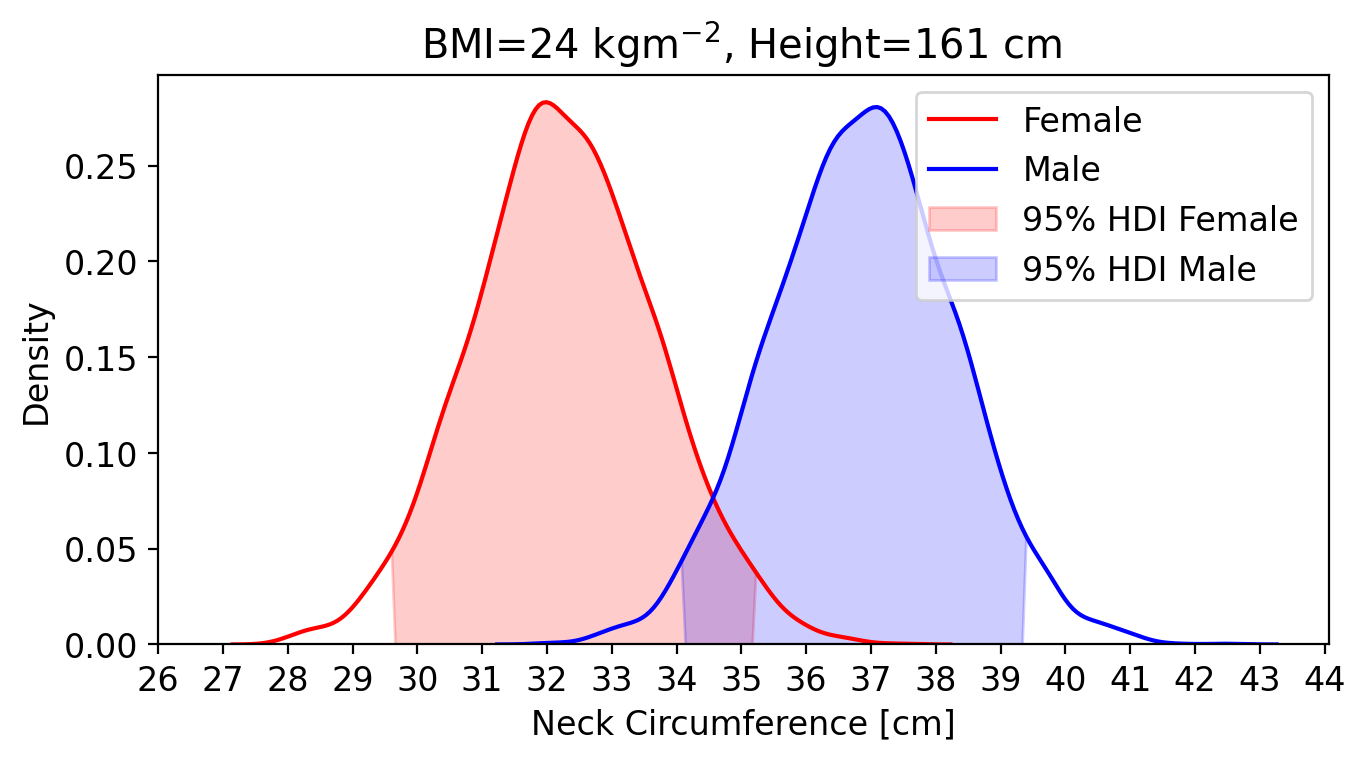

In [23]:
#| label: fig-HBM-prediction
#| fig-cap: "Prediction of Neck Circumference distribution for a specific Height and BMI"
f, ax0 = plt.subplots(1,1,figsize=(7, 4))
ax0.set_title("BMI=24 kgm$^{-2}$, Height=161 cm ")
sns.kdeplot(viva50F_F, color="r", ax=ax0)
sns.kdeplot(viva50F_M, color="b", ax=ax0)
kde_female_x, kde_female_y = ax0.lines[0].get_data()
low_female_int, high_female_int = az.hdi(viva50F_F[~np.isnan(viva50F_F)], hdi_prob=.95)
ax0.fill_between(kde_female_x, kde_female_y, where=(low_female_int< kde_female_x)& ( kde_female_x <high_female_int), color="red", alpha= 0.2, label="95% HDI Female",interpolate=True)
kde_male_x, kde_male_y = ax0.lines[1].get_data()
low_male_int, high_male_int = az.hdi(viva50F_M[~np.isnan(viva50F_M)])
ax0.fill_between(kde_male_x, kde_male_y, where=(low_male_int< kde_male_x)& ( kde_male_x <high_male_int), color="blue", alpha= 0.2, label="95% HDI Male",interpolate=True)
start, end = ax0.get_xlim()
ax0.xaxis.set_ticks(np.arange(np.round(start), end, 1))
ax0.set(xlabel="Neck Circumference [cm]")
ax0.legend(["Female","Male", "95% HDI Female","95% HDI Male"])
f.tight_layout()

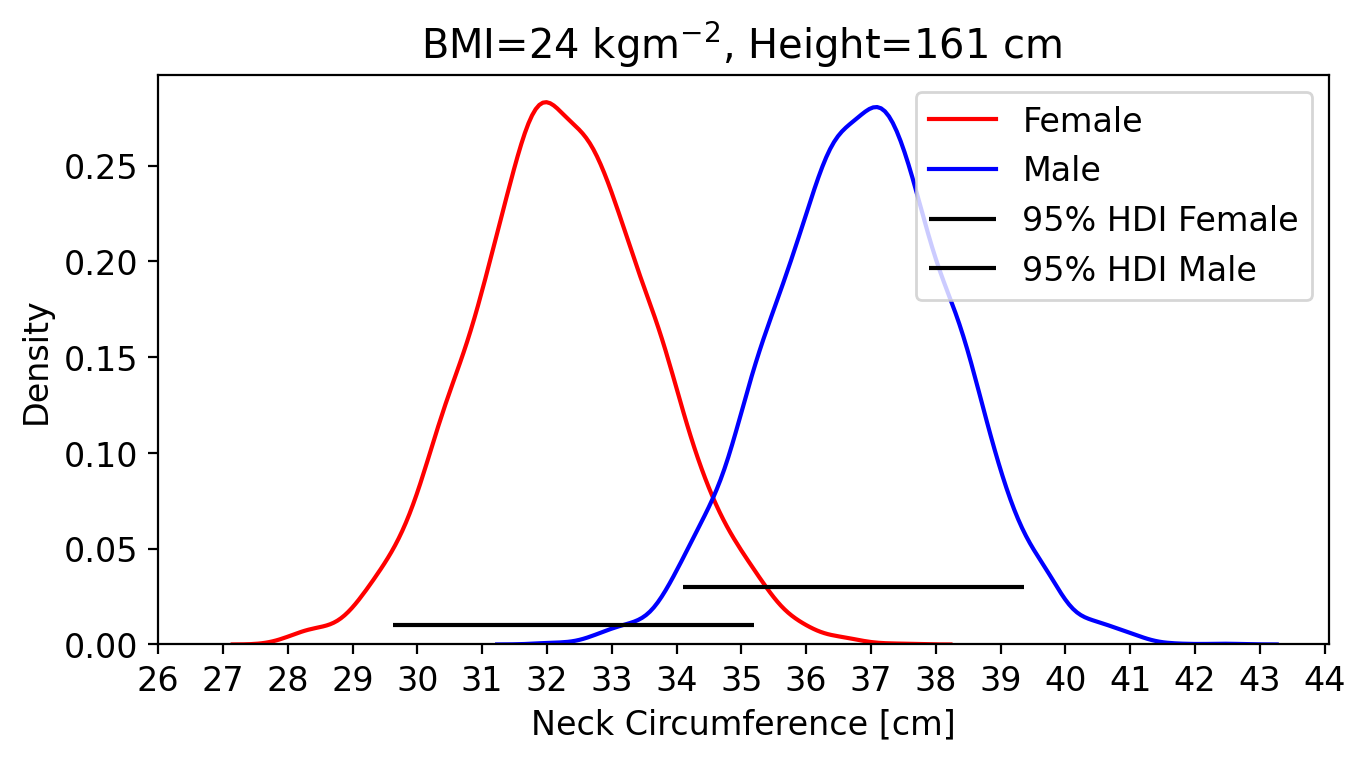

In [24]:
f, ax0 = plt.subplots(1,1,figsize=(7, 4))
ax0.set_title("BMI=24 kgm$^{-2}$, Height=161 cm ")
sns.kdeplot(viva50F_F, color="r", ax=ax0)
sns.kdeplot(viva50F_M, color="b", ax=ax0)
kde_female_x, kde_female_y = ax0.lines[0].get_data()
low_female_int, high_female_int = az.hdi(viva50F_F[~np.isnan(viva50F_F)], hdi_prob=.95)

ax0.hlines(0.01,low_female_int, high_female_int, "black" )
ax0.hlines(0.03,low_male_int, high_male_int, "black" )
# ax0.fill_between(kde_female_x, kde_female_y, where=(low_female_int< kde_female_x)& ( kde_female_x <high_female_int), color="red", alpha= 0.2, label="95% HDI Female",interpolate=True)
kde_male_x, kde_male_y = ax0.lines[1].get_data()
low_male_int, high_male_int = az.hdi(viva50F_M[~np.isnan(viva50F_M)])
# ax0.fill_between(kde_male_x, kde_male_y, where=(low_male_int< kde_male_x)& ( kde_male_x <high_male_int), color="blue", alpha= 0.2, label="95% HDI Male",interpolate=True)
# sns.kdeplot(viva50F_M - viva50F_F, color="black", alpha =0.5,ax=ax0)
start, end = ax0.get_xlim()
ax0.xaxis.set_ticks(np.arange(np.round(start), end, 1))
ax0.set(xlabel="Neck Circumference [cm]")
ax0.legend(["Female","Male", "95% HDI Female","95% HDI Male"])
f.tight_layout()

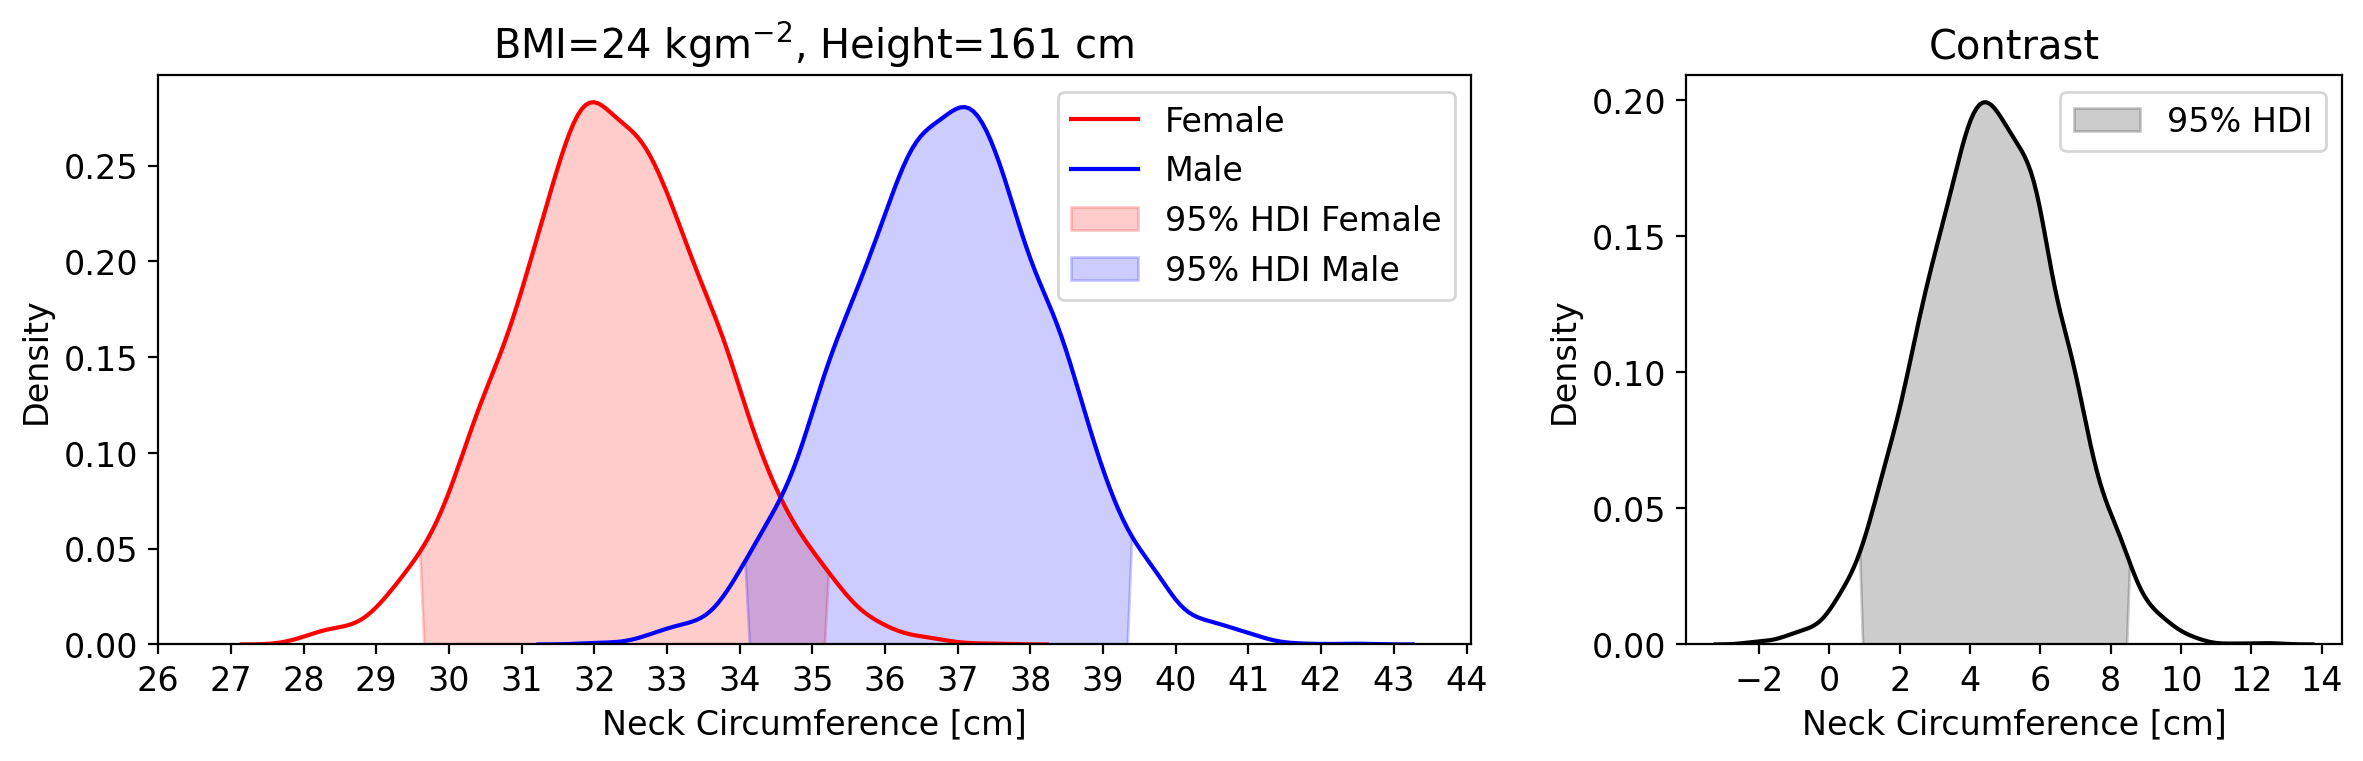

In [25]:
f, (ax0,ax1) = plt.subplots(1,2,figsize=(12, 4),gridspec_kw={'width_ratios': [2, 1]})
ax0.set_title("BMI=24 kgm$^{-2}$, Height=161 cm ")
sns.kdeplot(viva50F_F, color="r", ax=ax0)
sns.kdeplot(viva50F_M, color="b", ax=ax0)
kde_female_x, kde_female_y = ax0.lines[0].get_data()
low_female_int, high_female_int = az.hdi(viva50F_F[~np.isnan(viva50F_F)], hdi_prob=.95)
ax0.fill_between(kde_female_x, kde_female_y, where=(low_female_int< kde_female_x)& ( kde_female_x <high_female_int), color="red", alpha= 0.2, label="95% HDI Female",interpolate=True)
kde_male_x, kde_male_y = ax0.lines[1].get_data()
low_male_int, high_male_int = az.hdi(viva50F_M[~np.isnan(viva50F_M)])
ax0.fill_between(kde_male_x, kde_male_y, where=(low_male_int< kde_male_x)& ( kde_male_x <high_male_int), color="blue", alpha= 0.2, label="95% HDI Male",interpolate=True)
# sns.kdeplot(viva50F_M - viva50F_F, color="black", alpha =0.5,ax=ax0)
start, end = ax0.get_xlim()
ax0.xaxis.set_ticks(np.arange(np.round(start), end, 1))
ax0.set(xlabel="Neck Circumference [cm]")
ax0.legend(["Female","Male", "95% HDI Female","95% HDI Male"])


ax1.set_title("Contrast");ax1.set(xlabel="Neck Circumference [cm]")
sns.kdeplot((viva50F_M -viva50F_F)  , color="black", ax=ax1)
kde_contrast_x, kde_contrast_y = ax1.lines[0].get_data()
low_contrast_int, high_contrast_int = az.hdi((viva50F_M -viva50F_F)[~np.isnan(viva50F_M -viva50F_F)], hdi_prob=.95)
ax1.fill_between(kde_contrast_x, kde_contrast_y, where=(low_contrast_int< kde_contrast_x)& ( kde_contrast_x <high_contrast_int), color="black", alpha= 0.2, label="95% HDI",interpolate=True)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(np.round(start)+ 2 , end, 2))
ax1.legend()

f.tight_layout()
f.savefig("../images/Neck_circumference.png")

### Comparing Average 50M vs 50F

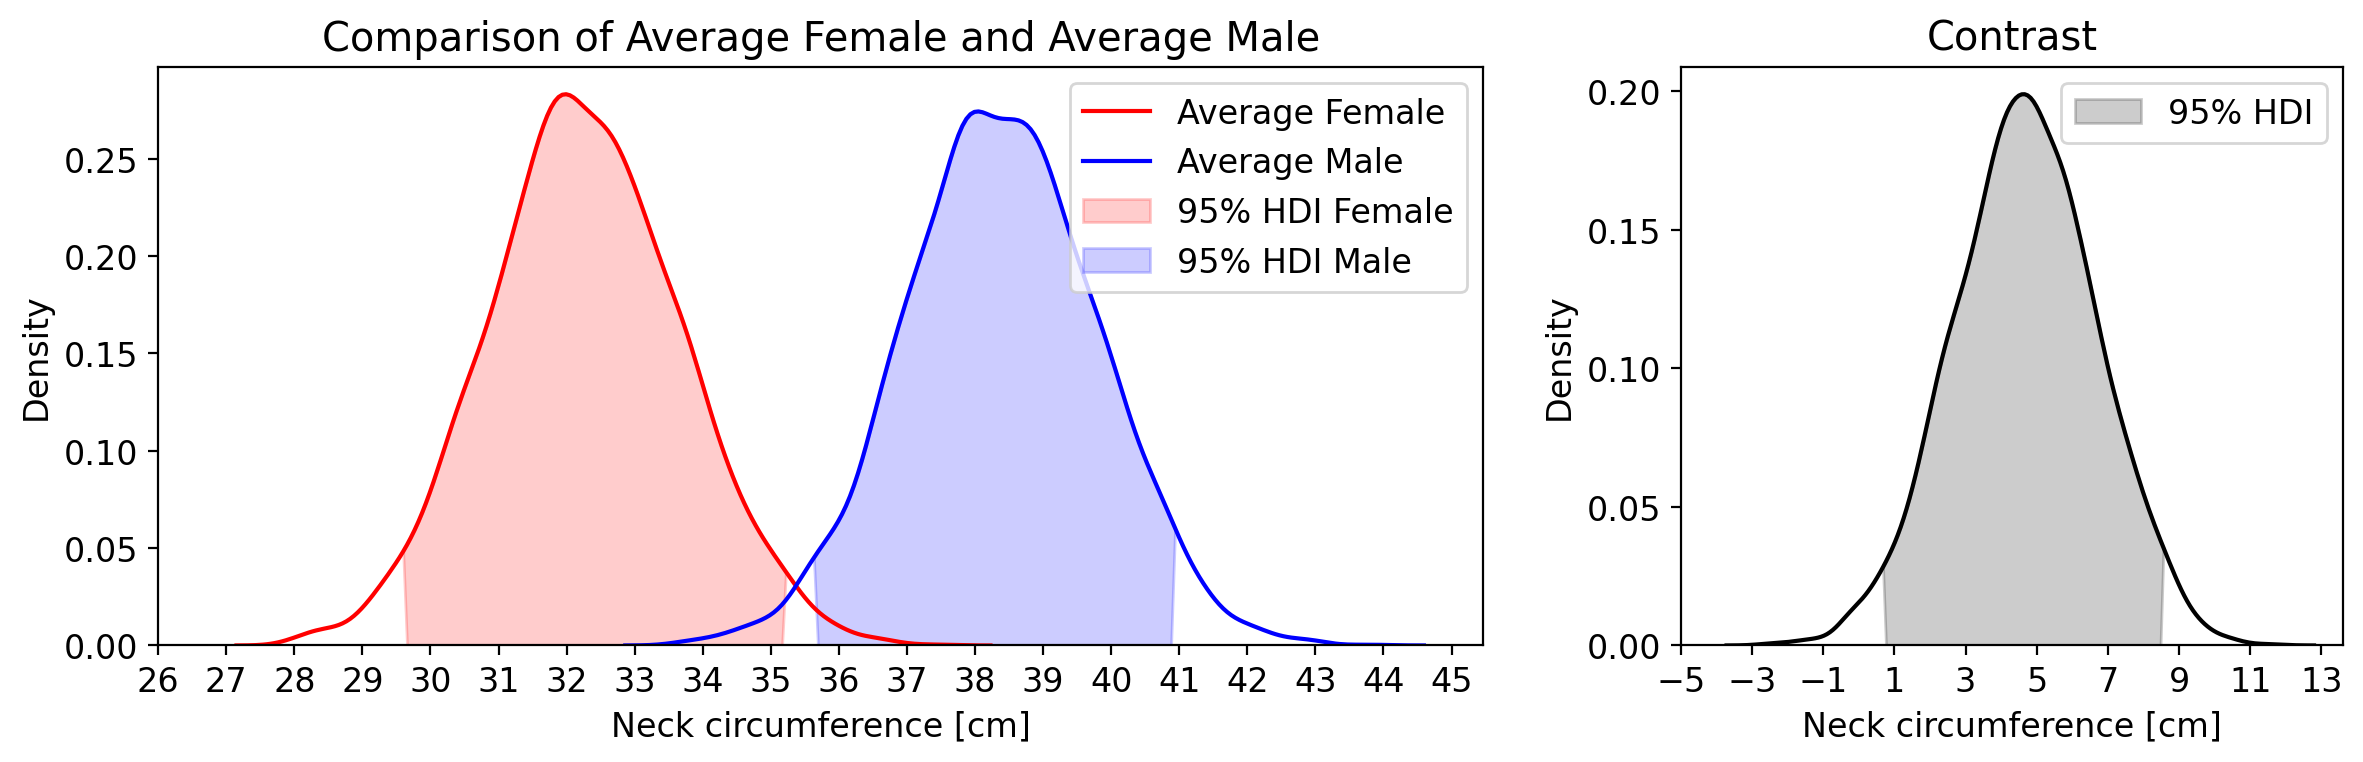

In [26]:
f, (ax0,ax1) = plt.subplots(1,2,figsize=(12, 4),gridspec_kw={'width_ratios': [2, 1]})
ax0.set_title("Comparison of Average Female and Average Male")
sns.kdeplot(viva50F_F, color="red", ax=ax0)
sns.kdeplot(viva50M_M, color="b", ax=ax0)
kde_female_x, kde_female_y = ax0.lines[0].get_data()
low_female_int, high_female_int = az.hdi(viva50F_F[~np.isnan(viva50F_F)], hdi_prob=.95)
ax0.fill_between(kde_female_x, kde_female_y, where=(low_female_int< kde_female_x)& ( kde_female_x <high_female_int), color="r", alpha= 0.2 ,label="95% HDI Female",interpolate=True)
kde_male_x, kde_male_y = ax0.lines[1].get_data()
low_male_int, high_male_int = az.hdi(viva50M_M[~np.isnan(viva50M_M)])
ax0.fill_between(kde_male_x, kde_male_y, where=(low_male_int< kde_male_x)& ( kde_male_x <high_male_int), color="b", alpha= 0.2, label="95% HDI Male",interpolate=True)
# sns.kdeplot(viva50M_M - viva50M_F, color="black", alpha =0.5,ax=ax0)
start, end = ax0.get_xlim()
ax0.xaxis.set_ticks(np.arange(np.round(start), end, 1))
ax0.set(xlabel="Neck circumference [cm]")
ax0.legend(["Average Female","Average Male", "95% HDI Female","95% HDI Male"])


ax1.set_title("Contrast");ax1.set(xlabel="Neck circumference [cm]")
sns.kdeplot((viva50M_M -viva50M_F)  , color="black", ax=ax1)
kde_contrast_x, kde_contrast_y = ax1.lines[0].get_data()
low_contrast_int, high_contrast_int = az.hdi((viva50M_M -viva50M_F)[~np.isnan(viva50M_M -viva50M_F)], hdi_prob=.95)
ax1.fill_between(kde_contrast_x, kde_contrast_y, where=(low_contrast_int< kde_contrast_x)& ( kde_contrast_x <high_contrast_int), color="black", alpha= 0.2, label="95% HDI",interpolate=True)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(np.round(start), end, 2))
ax1.legend()

f.tight_layout()
f.savefig("../images/Neck_circumference_Average.png")